<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# **Project 3: Web APIs & NLP**

### **Part 4: Modelling**

---

Import Libraries Here 

In [36]:
import pandas as pd 
import nltk

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier

from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

Import Files Here

In [37]:
df = pd.read_csv('../output/depression_happy_processed.csv')

### **Data Dictionary**
--- 

|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|*str*|depression_happy_processed|Unique ID for each post|
|author|*str*|depression_happy_processed|Represents the username of the post owner|
|score|*integer*|depression_happy_processed|The post number of posts upvotes minus downvotes|
|total comment|*float*|depression_happy_processed|Total number of comments on the reddit post |
|created_utc|*integer*|depression_happy_processed|The time stamp when the post is created in UNIX time form|
|subteddit|*str*|depression_happy_processed|Name of the subreddit where the post is extracted|
|title_and_body|*str*|depression_happy_processed|Content of the post|
|tokenize|*str*|depression_happy_processed|List of tokenized words from title_and_body|
|lemmatized|*str*|depression_happy_processed|List of lemmatized words|
|stemmed|*str*|depression_happy_processed|List of stemmed words|


Before creating model to predict if the texts falls under depression or happy, we will first convert them into numeric values:
- depression = 1
- happy = 0

In [38]:
#convert subreddit to binary value
df['subreddit'] = df['subreddit'].apply(lambda x: 1 if x == 'depression' else 0)

In [39]:
#define X and y
X = df['lemmatized']
y = df['subreddit']

In [40]:
#check proportion
y.value_counts(normalize=True)

subreddit
0    0.664494
1    0.335506
Name: proportion, dtype: float64

Because of imbalanced classes between `depression` and `happy`, it could lead the model to be bias towards the majority class(`happy`). The model may perform badly to identify minority class(`depression`), which is what we want to avoid. 

To balance out the class before going into modelling, we will take 50% random sample from `happy`.

In [41]:
#separate happy and depression to 2 dataframe
df_happy = df[df['subreddit'] == 0].reset_index(drop = True)
df_depression = df[df['subreddit'] == 1].reset_index(drop = True)

In [42]:
#random sample happy datasets
df_sample = df_happy.sample(n = df_happy.shape[0]//2,
                            replace = True,
                            random_state=42)

In [43]:
#concat the dataframe after sampling
df2_aftersample = pd.concat([df_depression,df_sample],axis=0)

Create train and test model

In [44]:
#define X and y
X = df2_aftersample['lemmatized']
y = df2_aftersample['subreddit']

Check depression and happy proportion

In [45]:
y.value_counts(normalize=True)

subreddit
1    0.50244
0    0.49756
Name: proportion, dtype: float64

Based on the proportion figures above, the proportion of classes between `happy(0)` and `depression(1)` is now balanced. We will proceed with train test split 

In [46]:
#create train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### **Modelling**
---

As a data scientist, we need to create several predictive model and compare which model gives the highest metrics score. For this project, we will compare 6 models and select the best model:

1. Naive Bayes with CounterVectorizer
2. Naive Bayes with TF-IDF
3. Logistic Regression with CounterVectorizer
4. Logistic Regression with TF-IDF
5. kNN with CounterVectorizer
6. kNN with TF-IDF

Before going to modelling, we will identify what metrics is important for our modelling

**Confusion matrix**

|              | Predicted Negative | Predicted Positive |
|--------------|--------------------|--------------------|
| Actual Negative |        TN          |        FP          |
| Actual Positive |        FN          |        TP          |

Interpretation:
- TN = Predicted not at risk of depression, and actual not at risk of depression
- FN = Predicted not at risk of depression, but actual at risk of depression
- TP = Predicted at risk of depression, and actual at risk of depression
- FP = Predicted at risk of depression, but actual not at risk of depression

Looking at the confusion matrix, we want to maximize TP and minimize FN
- Maximize TP: To get as many prediction that someone is at risk of depression as close as possible to actual 
- Minimize FN: To minimize predicting someone is not at risk of depression, but actually at risk of depression. We want to minimize this situation as much as possible because these group people may not receive necessary help due to the prediction error.

Judging from these 2, to maximize TP and minimize FP, our model will be evaluated based on `sensitivity`

### **Baseline model**

Evalute the 6 models using default hyperparameter

In [47]:
#Instantiate countervectorizer 
cvec = CountVectorizer()

In [48]:
#instantiate TF-IDF
tvec = TfidfVectorizer()

In [49]:
#fit and transfrom X_train with Counter Vectorizer
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns= cvec.get_feature_names_out())


In [50]:
#fit and transform X_train with TF-IDF
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(), columns = tvec.get_feature_names_out())

In [51]:
#transform X_test with Counter Vectorizer
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(),columns= cvec.get_feature_names_out())

In [52]:
#transform X_test with Counter Vectorizer
X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(),columns = tvec.get_feature_names_out())

In [53]:
#instantiate logistic regression
logreg= LogisticRegression()

#instantiate Naive Bayes 
nb = MultinomialNB()

#instantiate kNN
knn = KNeighborsClassifier()

In [54]:
#fit the model
#with countervectorizer
logreg_cvec_model = logreg.fit(X_train_cvec,y_train)
nb_cvec_model = nb.fit(X_train_cvec,y_train)
knn_cvec_model = knn.fit(X_train_cvec,y_train)

#with TF-IDF
logreg_tvec_model = logreg.fit(X_train_tvec,y_train)
nb_tvec_model = nb.fit(X_train_tvec,y_train)
knn_tvec_model = knn.fit(X_train_tvec,y_train)

In [55]:
#print and compare score 
print(f"Logistic Regression with CounterVectorizer train score {logreg_cvec_model.score(X_train_cvec,y_train)}")
print(f"Logistic Regression with CounterVectorizer test score {logreg_cvec_model.score(X_test_cvec,y_test)}")
print(f"Logistic Regression with TF-IDF train score {logreg_tvec_model.score(X_train_tvec,y_train)}")
print(f"Logistic Regression with TF-IDF test score {logreg_tvec_model.score(X_test_tvec,y_test)}")
print(f"Naive Bayes with CounterVectorizer train score {nb_cvec_model.score(X_train_cvec,y_train)}")
print(f"Naive Bayes with CounterVectorizer test score {nb_cvec_model.score(X_test_cvec,y_test)}")
print(f"Naive Bayes with TF-IDF train score {nb_tvec_model.score(X_train_tvec,y_train)}")
print(f"Naive Bayes with TF-IDF test score {nb_tvec_model.score(X_test_tvec,y_test)}")
print(f"kNN with CounterVectorizer train score {knn_cvec_model.score(X_train_cvec,y_train)}")
print(f"kNN with CounterVectorizer test score {knn_cvec_model.score(X_test_cvec,y_test)}")
print(f"kNN with TF-IDF train score {knn_tvec_model.score(X_train_tvec,y_train)}")
print(f"kNN with TF-IDF test score {knn_tvec_model.score(X_test_tvec,y_test)}")


Logistic Regression with CounterVectorizer train score 0.8754880694143167
Logistic Regression with CounterVectorizer test score 0.8399826539462273
Logistic Regression with TF-IDF train score 0.9096167751265365
Logistic Regression with TF-IDF test score 0.8564614050303556
Naive Bayes with CounterVectorizer train score 0.8357194504699927
Naive Bayes with CounterVectorizer test score 0.7931483087597572
Naive Bayes with TF-IDF train score 0.853651482284888
Naive Bayes with TF-IDF test score 0.7992194275802255
kNN with CounterVectorizer train score 0.8490238611713666
kNN with CounterVectorizer test score 0.7909800520381614
kNN with TF-IDF train score 0.5454808387563268
kNN with TF-IDF test score 0.5121422376409367


In [56]:
#create confusion matrix 
tn1_base, fp1_base, fn1_base, tp1_base = confusion_matrix(y_test,logreg_cvec_model.predict(X_test_cvec)).ravel()
tn2_base, fp2_base, fn2_base, tp2_base = confusion_matrix(y_test,logreg_tvec_model.predict(X_test_tvec)).ravel()
tn3_base, fp3_base, fn3_base, tp3_base = confusion_matrix(y_test,nb_cvec_model.predict(X_test_cvec)).ravel()
tn4_base, fp4_base, fn4_base, tp4_base = confusion_matrix(y_test,nb_tvec_model.predict(X_test_tvec)).ravel()
tn5_base, fp5_base, fn5_base, tp5_base = confusion_matrix(y_test,knn_cvec_model.predict(X_test_cvec)).ravel()
tn6_base, fp6_base, fn6_base, tp6_base = confusion_matrix(y_test,knn_tvec_model.predict(X_test_tvec)).ravel()

In [57]:
#print sensitivity values
sen_logreg_cvec_base = tp1_base / (tp1_base+fn1_base)
print(f"Sensitivity Logistic Regression with Counter Vectorizer value: {sen_logreg_cvec_base : 0.2%}")
sen_logreg_tvec_base = tp2_base / (tp2_base+fn2_base)
print(f"Sensitivity Logistic Regression with TF-IDF value: {sen_logreg_tvec_base : 0.2%}")
sen_nb_cvec_base = tp3_base / (tp3_base+fn3_base)
print(f"Sensitivity Naive Bayes with Counter Vectorizer value: {sen_nb_cvec_base : 0.2%}")
sen_nb_tvec_base = tp4_base / (tp4_base+fn4_base)
print(f"Sensitivity Naive Bayes with TF-IDF value: {sen_nb_tvec_base : 0.2%}")
sen_knn_cvec_base = tp5_base / (tp5_base+fn5_base)
print(f"Sensitivity kNN with Counter Vectorizer value: {sen_knn_cvec_base : 0.2%}")
sen_knn_tvec_base = tp6_base / (tp6_base+fn6_base)
print(f"Sensitivity kNN with TF-IDF value: {sen_knn_tvec_base : 0.2%}")

Sensitivity Logistic Regression with Counter Vectorizer value:  89.13%
Sensitivity Logistic Regression with TF-IDF value:  84.56%
Sensitivity Naive Bayes with Counter Vectorizer value:  95.51%
Sensitivity Naive Bayes with TF-IDF value:  95.60%
Sensitivity kNN with Counter Vectorizer value:  73.34%
Sensitivity kNN with TF-IDF value:  5.09%


Summary of baseline model accuracy score 

||Naive Bayes|Logistic Regression|k Nearest Neighbor|
|---|---|---|---|
|CounterVectorizer|train = 0.83 <br> test = 0.79|train = 0.87 <br> test = 0.83|train = 0.84 <br> test = 0.79|
|TF-IDF|train = 0.85 <br> test = 0.79|train = 0.90 <br> test = 0.83|train = 0.54 <br> test = 0.79|

**Summary of `sensitivity` scores between 6 models**

||Naive Bayes|Logistic Regression|k Nearest Neighbor|
|---|---|---|---|
|CounterVectorizer|95.51%|89.13%|73.34%|
|TF-IDF|95.6%|84.56%|5.09%|


Looking at the sensitivity score, Naive Bayes with TF-IDF has the best score, however the model overfits based on the train test score. We will further do hypertuning, on other models as well to see how they perform after hypertuning

### **HyperParameter Tuning for Each Model**

### **Naive Bayes Model**

1. Settings to be used for this modelling 
    - Model : Naive Bayes
    - Vectorizer : Countervectorizer

In [58]:
#instantiate pipeline 

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
    ])

In [59]:
#set parameters for the pipeline

pipe_params = {
    'cvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df' : [1,2],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)]
}

In [60]:
#instantiate gridsearch
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [61]:
#fit model to training data 
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [62]:
print(gs.best_score_)

0.8010122921185829


 Create confusion matrix

In [63]:
#get prediction
nb_cvec_preds = gs.predict(X_test)

#save confusion matrix
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, nb_cvec_preds).ravel()


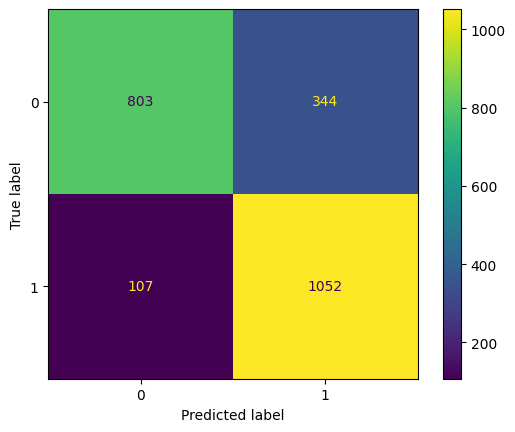

In [64]:
#show confusion matrix values
cm_nb_cvec = confusion_matrix(y_test,nb_cvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_nb_cvec, 
                             display_labels=gs.best_estimator_.classes_)
disp.plot();


In [65]:
#sensitivity score
sen_nb_cvec = tp1 / (tp1+fn1)
print(f"Sensitivity value: {sen_nb_cvec : 0.2%}")

Sensitivity value:  90.77%


2. Settings to be used for this modelling 
    - Model : Naive Bayes
    - Vectorizer : TF-IDF

In [66]:
#setup pipeline

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [67]:
#set parameter 

pipe_tvec_params = {
    'tvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range' : [(1,1),(1,2),(2,2)]
}

In [68]:
gs_tvec = GridSearchCV(pipe_tvec,
                       param_grid=pipe_tvec_params,
                       cv=5)

In [69]:
gs_tvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [70]:
#print best score
gs_tvec.best_score_

0.7982646420824295

In [71]:
print(gs_tvec.best_params_)

{'tvec__max_features': 3000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [72]:
#determine log probability
feature_name = gs_tvec.best_estimator_.named_steps['tvec'].get_feature_names_out()

feature_log_probs = gs_tvec.best_estimator_.named_steps['nb'].feature_log_prob_

feature_probs_df = pd.DataFrame(feature_log_probs.T, columns=['happy', 'depression'], index=feature_name)

In [73]:
feature_probs_df['depression'].sort_values(ascending=False)[0:10]

depression   -5.264284
fuck         -5.553051
anymore      -5.665220
care         -5.685180
depress      -5.697854
maybe        -5.720305
nothing      -5.744253
hate         -5.755755
point        -5.769996
die          -5.789403
Name: depression, dtype: float64

In [74]:
feature_probs_df['happy'].sort_values(ascending=False)[0:10]

congratulations   -4.295181
welcome           -4.542019
congrats          -4.779757
great             -4.916154
beautiful         -5.233240
celebrate         -5.264428
awesome           -5.271761
proud             -5.288925
positivity        -5.327363
question          -5.333409
Name: happy, dtype: float64

Create Confusion Matrix

In [75]:
#get prediction
nb_tvec_preds = gs_tvec.predict(X_test)
#save confusion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test,nb_tvec_preds).ravel()

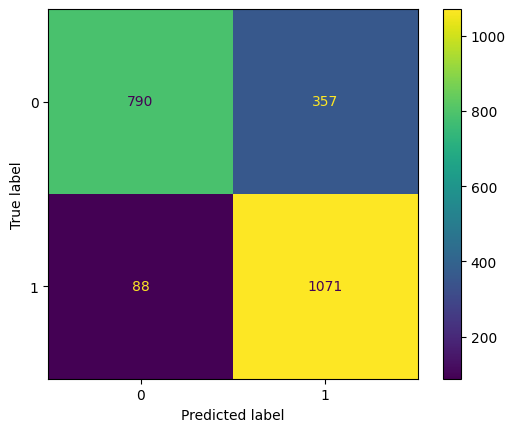

In [76]:
#show confusion matrix values
cm_nb_tvec = confusion_matrix(y_test,nb_tvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_nb_tvec, 
                             display_labels=gs_tvec.best_estimator_.classes_)
disp.plot();

In [77]:
#sensitivity score
sen_nb_tvec = tp2 / (tp2+fn2)
print(f"Sensitivity value: {sen_nb_tvec : 0.2%}")

Sensitivity value:  92.41%


### **Logistic Regression**

1. Settings to be used for this modelling 
    - Model : Logistic Regression
    - Vectorizer : Countervectorizer

In [30]:
#instantiate pipeline 
pipe_logreg_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [31]:
pipe_logreg_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df' : [1,2],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'logreg__C' : [0.1,1,10],
    'logreg__penalty' : ['l1','l2']
}

In [32]:
gs_logreg_cvec  = GridSearchCV(pipe_logreg_cvec,
                               param_grid= pipe_logreg_cvec_params,
                               cv = 5)

In [33]:
gs_logreg_cvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'logreg__C': [0.1, 1, 10],
                         'logreg__penalty': ['l1', 'l2']})

In [34]:
#check best score 
gs_logreg_cvec.best_score_

0.8335502530730297

Create Confusion Matrix 

In [35]:
#get prediction
logreg_cvec_preds = gs_logreg_cvec.predict(X_test)

#save confusion matrix
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, logreg_cvec_preds).ravel()

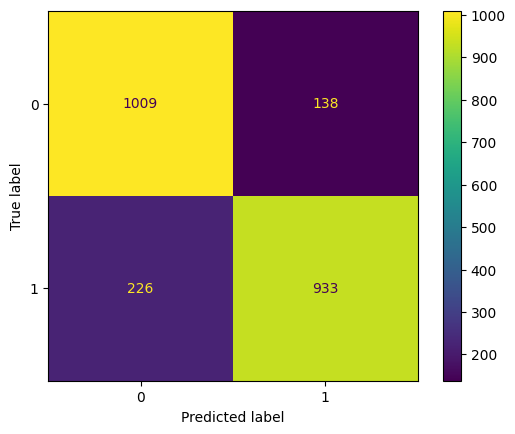

In [36]:
#show confusion matrix values
cm_logreg_cvec = confusion_matrix(y_test,logreg_cvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_logreg_cvec, 
                             display_labels=gs_logreg_cvec.best_estimator_.classes_)
disp.plot();

In [37]:
#sensitivity score
sen_logreg_cvec = tp3 / (tp3+fn3)
print(f"Sensitivity value: {sen_logreg_cvec : 0.2%}")

Sensitivity value:  80.50%


2. Settings to be used for this modelling 
    - Model : Logistic Regression
    - Vectorizer : TF-IDF

In [38]:
#setup pipeline
pipe_logreg_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [39]:
#set pipeline parameters
pipe_logreg_tvec_params = {  
    'tvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'logreg__C' : [0.1,1,10],
    'logreg__penalty' : ['l1','l2']
}

In [40]:
gs_logreg_tvec = GridSearchCV(pipe_logreg_tvec,
                              param_grid=pipe_logreg_tvec_params,
                              cv=5)

In [41]:
gs_logreg_tvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 1, 10],
                         'logreg__penalty': ['l1', 'l2'],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [42]:
#check best score 
gs_logreg_tvec.best_score_

0.8493130874909616

Create Confusion Matrix

In [44]:
#get prediction
logreg_tvec_preds = gs_logreg_tvec.predict(X_test)

#save confusion matrix
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, logreg_tvec_preds).ravel()

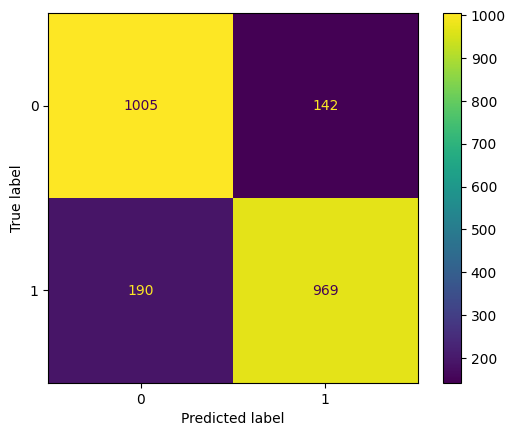

In [45]:
#show confusion matrix values
cm_logreg_tvec = confusion_matrix(y_test,logreg_tvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_logreg_tvec, 
                             display_labels=gs_logreg_tvec.best_estimator_.classes_)
disp.plot();

In [46]:
#sensitivity score
sen_logreg_tvec = tp4 / (tp4+fn4)
print(f"Sensitivity value: {sen_logreg_tvec : 0.2%}")

Sensitivity value:  83.61%


### **K Nearest Neighbor**

1. Settings to be used for this modelling 
    - Model : kNN
    - Vectorizer : Countervectorizer

In [47]:
#setup pipeline 

pipe_knn_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [48]:
#setup paratameters for pipeline 
pipe_knn_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df' : [1,2],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'knn__n_neighbors' : [5,10,15],
    'knn__weights' : ['uniform', 'distance'],
    'knn__p' : [1,2]
}

In [49]:
#instantiate Gridsearch
gs_knn_cvec = GridSearchCV(pipe_knn_cvec,
                           param_grid=pipe_knn_cvec_params,
                           cv=5,
                           verbose=1)

In [50]:
gs_knn_cvec.fit(X_train,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'knn__n_neighbors': [5, 10, 15], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             verbose=1)

In [51]:
#check best score 
gs_knn_cvec.best_score_

0.7240780911062906

Create Confusion Matrix

In [53]:
#get prediction
knn_cvec_preds = gs_knn_cvec.predict(X_test)

#save confusion matrix
tn5, fp5, fn5, tp5 = confusion_matrix(y_test, knn_cvec_preds).ravel()

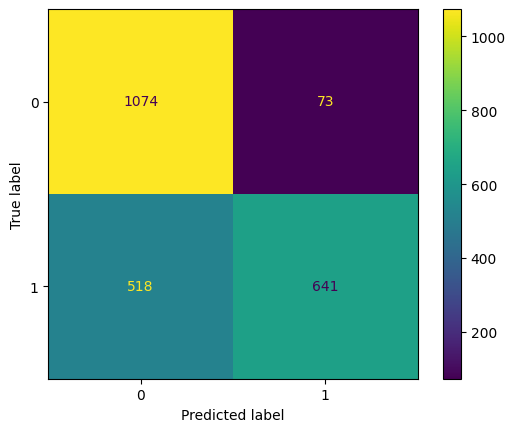

In [54]:
#show confusion matrix values
cm_knn_cvec = confusion_matrix(y_test,knn_cvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_knn_cvec, 
                             display_labels=gs_knn_cvec.best_estimator_.classes_)
disp.plot();

In [55]:
#sensitivity score
sen_knn_cvec = tp5 / (tp5+fn5)
print(f"Sensitivity value: {sen_knn_cvec : 0.2%}")

Sensitivity value:  55.31%


2. Settings to be used for this modelling 
    - Model : kNN
    - Vectorizer : TF-IDF

In [56]:
#instantiate pipeline 
pipe_knn_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [57]:
pipe_knn_tvec_params = {
    'tvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'knn__n_neighbors' : [5,10,15],
    'knn__weights' : ['uniform', 'distance'],
    'knn__p' : [1,2]
}

In [58]:
#instantiate Gridsearch
gs_knn_tvec = GridSearchCV(pipe_knn_tvec,
                           param_grid=pipe_knn_tvec_params,
                           cv=5,
                           verbose=1)

In [59]:
gs_knn_tvec.fit(X_train,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 10, 15], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [60]:
#check best score 
gs_knn_tvec.best_score_

0.6013015184381779

Create Confusion Matrix

In [61]:
#get prediction
knn_tvec_preds = gs_knn_tvec.predict(X_test)

#save confusion matrix
tn6, fp6, fn6, tp6 = confusion_matrix(y_test, knn_tvec_preds).ravel()

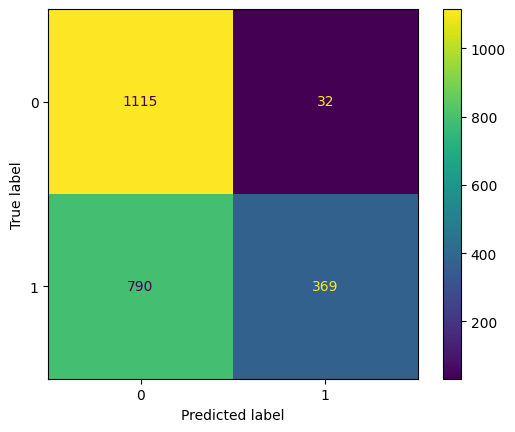

In [62]:
#show confusion matrix values
cm_knn_tvec = confusion_matrix(y_test,knn_tvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_knn_tvec, 
                             display_labels=gs_knn_tvec.best_estimator_.classes_)
disp.plot();

In [63]:
#sensitivity score
sen_knn_tvec = tp6 / (tp6+fn6)
print(f"Sensitivity value: {sen_knn_tvec : 0.2%}")

Sensitivity value:  31.84%


#### Summary of Score
---

In [185]:
print(f"Naive Bayes Model with Countervectorizer train score : {gs.score(X_train,y_train)}")
print(f"Naive Bayes Model with Countervectorizer test score : {gs.score(X_test,y_test)}")
print(f"Naive Bayes Model with TF-IDF train score : {gs_tvec.score(X_train,y_train)}")
print(f"Naive Bayes Model with TF-IDF test score : {gs_tvec.score(X_test,y_test)}")
print(f"Logistic Regression with Countervectorizer train score : {gs_logreg_cvec.score(X_train,y_train)}")
print(f"Logistic Regression with Countervectorizer test score : {gs_logreg_cvec.score(X_test,y_test)}")
print(f"Logistic Regression with TF-IDF train score : {gs_logreg_tvec.score(X_train,y_train)}")
print(f"Logistic Regression with TF-IDF test score : {gs_logreg_tvec.score(X_test,y_test)}")
print(f"kNN with Countervectorizer train score : {gs_knn_cvec.score(X_train,y_train)}")
print(f"kNN with Countervectorizer test score : {gs_knn_cvec.score(X_test,y_test)}")
print(f"kNN with TF-IDF train score : {gs_knn_tvec.score(X_train,y_train)}")
print(f"kNN with TF-IDF test score : {gs_knn_tvec.score(X_test,y_test)}")

Naive Bayes Model with Countervectorizer train score : 0.8422270426608821
Naive Bayes Model with Countervectorizer test score : 0.8044232437120555
Naive Bayes Model with TF-IDF train score : 0.8399132321041215
Naive Bayes Model with TF-IDF test score : 0.8070251517779705
Logistic Regression with Countervectorizer train score : 0.9586406362979031
Logistic Regression with Countervectorizer test score : 0.8421509106678231
Logistic Regression with TF-IDF train score : 0.9466377440347071
Logistic Regression with TF-IDF test score : 0.8560277536860365
kNN with Countervectorizer train score : 0.9639913232104121
kNN with Countervectorizer test score : 0.7437120555073721
kNN with TF-IDF train score : 0.768763557483731
kNN with TF-IDF test score : 0.6435385949696444


**Summary of models train and test accuracy score**

||Naive Bayes|Logistics Regression|k Nearest Neighbor|
|---|---|---|---|
|CounterVectorizer|train = 0.84 <br> test = 0.80|train = 0.95 <br> test = 0.84|train = 0.96 <br> test = 0.74|
|TF-IDF|train = 0.83 <br> test = 0.80|train = 0.94 <br> test = 0.85|train = 0.76 <br> test = 0.64|

Looking at the 6 models after hypertuning, Naive Bayes Model with TF-IDF seems to perform the best. It fits the best among the 6 models due to its train and test value have the least difference.

However, our metrics for this project is not measured based on accuracy. We will look into confusion matrix to determine which metrics are the most important to be evaluated.

**Summary of Naive Bayes with TF-IDF Model Score**

||Baseline|Hypertuned|
|---|---|---|
|train score|85.36%|83.99%|
|test score|79.99%|80.70%|
|sensitivity|95.6%|92.41%|

We select hypertuned `Naive Bayes with TF-IDF` as our model since it has the best `sensitivity` score and the model fits better than baseline 

Best parameters for this model based on GridSearch
- tvec__max_features: 3000
- tvec__ngram_range: (1, 1)
- tvec__stop_words: None

### **Conclusion**
---

- We might identify youth at risk of depression by detecting words that indicate Depression
- The most indicative of Depression: depression, fuck, anymore
- Depression is a serious and prevalent in our society issue that needs to be addressed at a young age 
- Instead of waiting for youths to seek help, with our model, we can be more proactive in identifying those at risk of depression through observing their language.

### **Recommendations**
---

- Social Media companies can apply our predictive model when youths post online 
- Those who are then identified by our model to be at risk of suffering from depression can then be referred to support organisations (eg. Care Corner, Tinkle Friend) 


### **Future Plans**
---

- Work with MOE and apply our model to their database of students’ termly check in surveys so that schools can also take action to support the student 
- Incorporate our model into the social media platform, similar to autocorrect function which detects misspelt words
- Explore possible partnerships with search engines to do predictions based on their searches 
- Model future improvement:
    - The model may not be able to detect words in short form or slang, which are distinct to their own countries. Adding this slang words to our train datasets could further improve its metrics score.
    - The model may falsely detect sarcastic posts.


### **Prediction Simulation**
---

In this part of the notebook, we will use the selected model to predict if a reddit post falls under the category of having depression or not. The sample posts are taken from other subreddit besides `r/depression` and `r/happy` 

1. Preparation 

---

Copy custom stopwords identified on notebook part 3

In [65]:
custom_stopwords = ['ur','us','may','many', 'nd', 'either', 'might', 'unless',
                    'even', 'https', 'en', 'org', 'name', 'two' , 'im', 'ive',
                    'yet', 'two', 'op', 'ops', 'usually', 'pm', 'pms', 'else',
                    'often', 'ones', 'would', 'alt', 'others', 'except', 'many',
                    'much','also', 'always', 'www', 'com', 'since', 'everyone',
                    'ysk', 'yalls', 'cuz','coulda', 'really', 'day', 'ei',
                    'ol', 'nada', 'year','years', 'oc', 'month', 'hours','week',
                    'day', 'awwww', 'btw'
                    ]

Create function to filter out stopwrods

In [66]:
def custom_stopword_filter(data, stopword):
    data = pd.Series(data)
    # print(data)
    filtered_data = []
    for word in data:
        if word not in stopword:
            filtered_data.append(word)
        else:
            continue
        # print(data[i])
        # filtered_data.append([word for word in data[i] if word not in stopword])

    # print(filtered_data) 
    return filtered_data

Create function to predict the outcome of a text inserted into the function

Expected output:
1. Have depression
2. No depression

In [67]:
def predictor(text):
    #instantiate tokenizer
    tokenizer = RegexpTokenizer(r'[a-z]\w+')
    token = tokenizer.tokenize(text)
    #filter stopword english
    filtered_word = custom_stopword_filter(token, stopword = stopwords.words('english'))
    #filtered custom word
    filtered_word = custom_stopword_filter(filtered_word , custom_stopwords)
   
    preds = gs_tvec.predict([' '.join(filtered_word)])

    if preds == 1:
        print("You have depression")
    else:
        print("No depression")

    
    

2. Prediction

---

Prediction 2.1: 

`r/mentalhealh` is a forum to discuss, vent, support and share information about mental health, illness and wellness

Sample Post: [Source r/mentalhealth](https://www.reddit.com/r/mentalhealth/comments/1bnib6u/my_ex_said_i_sexually_assaulted_her/)

*So the incident happened a few months ago, me and my girlfriend at the time were getting intimate and she asked me if she could suck it so I said well you could sit on it and she obliged. During the sex (she was ontop) she said she was tired to I asked her to keep going and she did, eventually she got off and looked upset so I asked her about what was up and she said I didn’t listen to her and what not and I felt a great deal of guilt. Anyway we spoke about it more and I asked her if I held her down or did I rape her or did I sexually assault her and she said I didn’t to all of that. So we split up earlier this month and she came up to me today saying how I did this that and the other and that incident came up, she said I held my hands on her hips which I didn’t and she said I sexually assaulted her, she also said she wants nothing to do with me. Closer to the time of the incident she spoke to one of our mutuals about it who at first was angry but then when I spoke to them about it and said what happened in more detail about the incident they said I shouldn’t feel guilty but right now I feel so shit about the whole thing. She’s adding things that didn’t happen to the story yes but something still happened and I just don’t know what to do*

In [68]:
text_sample = "So the incident happened a few months ago, me and my girlfriend at the time were getting intimate and she asked me if she could suck it so I said well you could sit on it and she obliged. During the sex (she was ontop) she said she was tired to I asked her to keep going and she did, eventually she got off and looked upset so I asked her about what was up and she said I didn’t listen to her and what not and I felt a great deal of guilt. Anyway we spoke about it more and I asked her if I held her down or did I rape her or did I sexually assault her and she said I didn’t to all of that. So we split up earlier this month and she came up to me today saying how I did this that and the other and that incident came up, she said I held my hands on her hips which I didn’t and she said I sexually assaulted her, she also said she wants nothing to do with me. Closer to the time of the incident she spoke to one of our mutuals about it who at first was angry but then when I spoke to them about it and said what happened in more detail about the incident they said I shouldn’t feel guilty but right now I feel so shit about the whole thing. She’s adding things that didn’t happen to the story yes but something still happened and I just don’t know what to do"

In [69]:
predictor(text_sample)

You have depression


Prediction 2.2

r/positivity is a subreddit forum to share positive and uplifting stories

Sample Post: [Source r/positivity](https://www.reddit.com/r/Positivity/comments/1bnqbbx/life_is_so_cool/)

*just sat down to have a snack and got ran over by a feeling of gratefulness and contentment when i looked down at the cup of coffee and grilled cheese i made life is so cool dude*

In [70]:
text_sample_2 = "just sat down to have a snack and got ran over by a feeling of gratefulness and contentment when i looked down at the cup of coffee and grilled cheese i made life is so cool dude"

In [71]:
predictor(text_sample_2)

No depression
